# DMS - Data Analysis

In [48]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from abag_affinity.utils.config import read_config, get_data_paths

In [49]:
config = read_config("../../config.yaml")

In [50]:
publications = os.listdir(os.path.join(config["DATA"]["path"], config["DATA"]["DMS"]["folder_path"]))
publications = [ ".".join(pub.split(".")[:-1]) for pub in publications if ".csv" in pub]
publications

['madan21_mutat_hiv',
 'mason21_comb_optim_therap_antib_by_predic_combined_H3_3',
 'wu20_differ_ha_h3_h1',
 'b.20_funct_screen_strat_engin_chimer',
 'phillips21_bindin',
 'mason21_optim_therap_antib_by_predic_dms_H',
 'mason21_comb_optim_therap_antib_by_predic_combined_H3_2',
 'mason21_comb_optim_therap_antib_by_predic_combined_L3_3',
 'wu17_in',
 'starr21_prosp_covid',
 'mason21_comb_optim_therap_antib_by_predic_combined_H3_1',
 'mason21_optim_therap_antib_by_predic_dms_L']

In [51]:
full_dms_df = pd.read_csv(os.path.join(config["DATA"]["path"], "data", "DMS", "dms_curated.csv"))
full_dms_df = full_dms_df[~full_dms_df["publication"].str.startswith("taft22")]

all_complexes = full_dms_df.groupby(["publication", "antibody", "antigen"])

In [52]:
dfs = []
for publication in publications:
    df = pd.read_csv(os.path.join(config["DATA"]["path"], config["DATA"]["DMS"]["folder_path"], f"{publication}.csv"))
    dfs.append(df)

    
dms_df = pd.concat(dfs)

In [53]:
len(dms_df)

467815

In [54]:
dms_df[["publication", "antibody", "antigen"]] = dms_df["pdb"].str.split(':', 2, expand=True)

In [55]:
dms_df = dms_df.reset_index(drop=True)

In [56]:
#dms_df[(dms_df["publication"] == "wu20_differ_ha_h3_h1") & (dms_df["mutation_code"] == "IB45T")]

In [57]:
complexes = dms_df.groupby(["publication", "antibody", "antigen"])

### Number of mutations for complex

<AxesSubplot:xlabel='publication,antibody,antigen'>

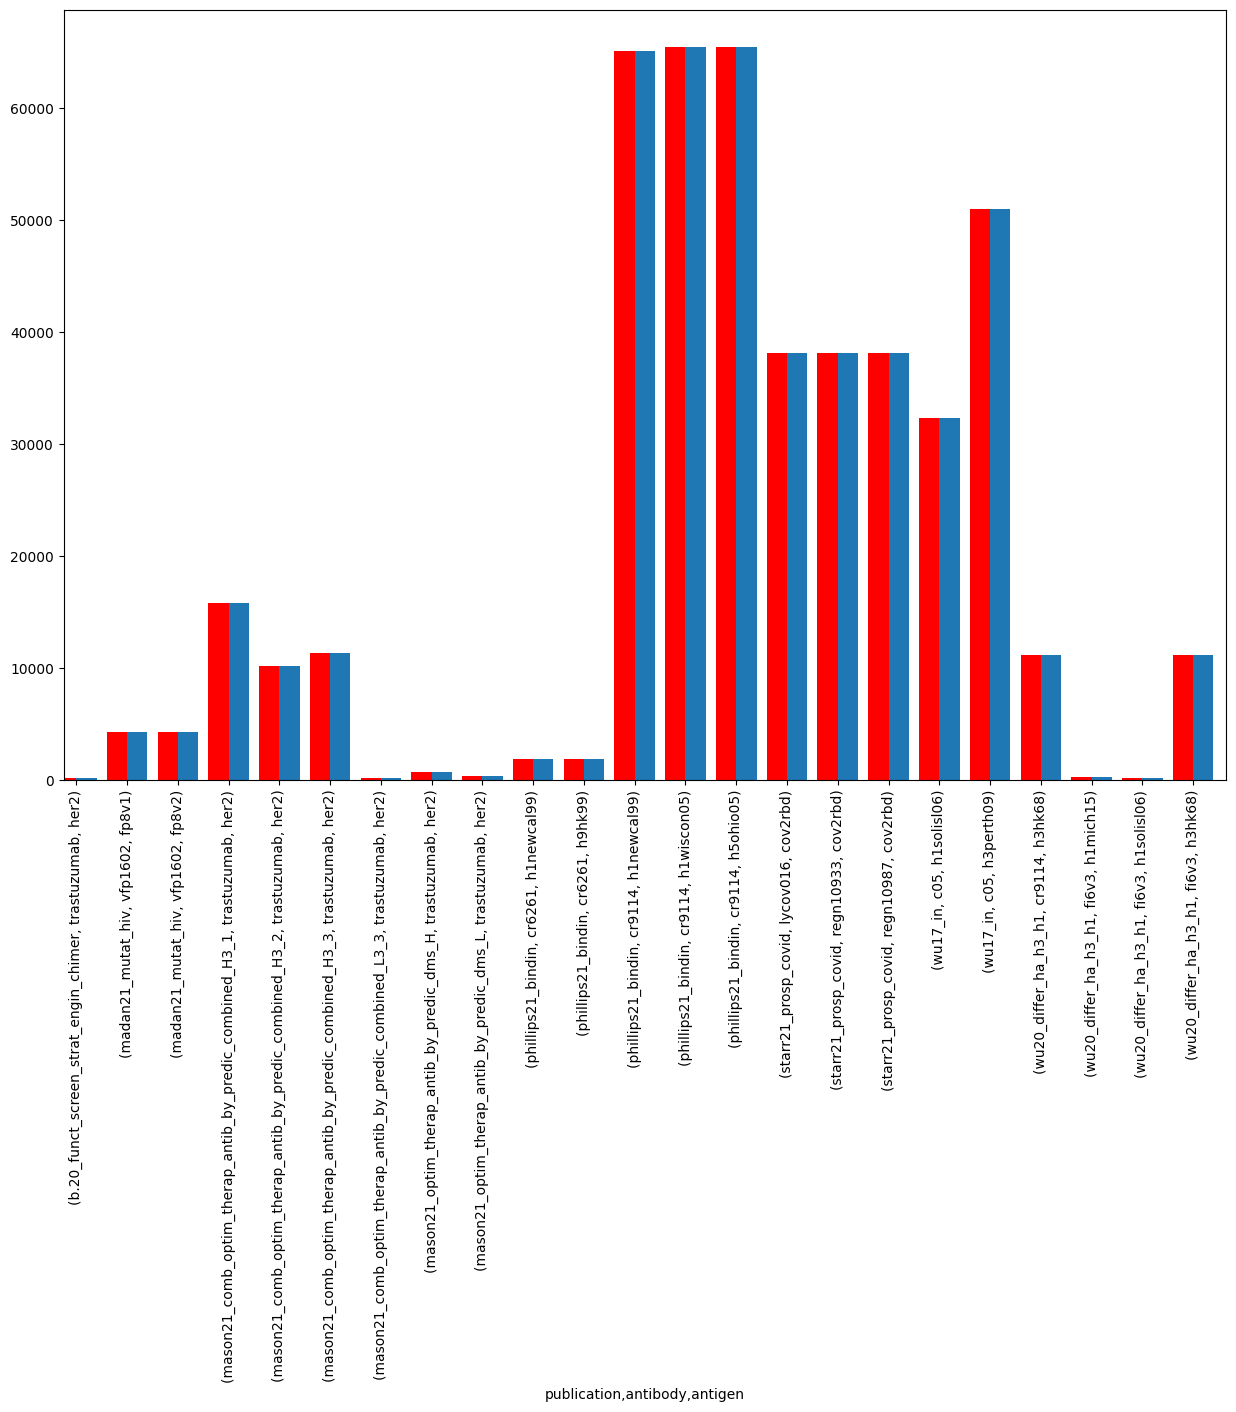

In [58]:
# check if all data points are available
fig = plt.figure(figsize=(15,10))

ax = fig.add_subplot(111) 

width = 0.4

all_complexes["mutation_code"].count().plot(kind="bar", ax=ax, width=width, position=1, color="red")
complexes["mutation_code"].count().plot(kind="bar", ax=ax, width=width, position=0)

<AxesSubplot:ylabel='publication,antibody,antigen'>

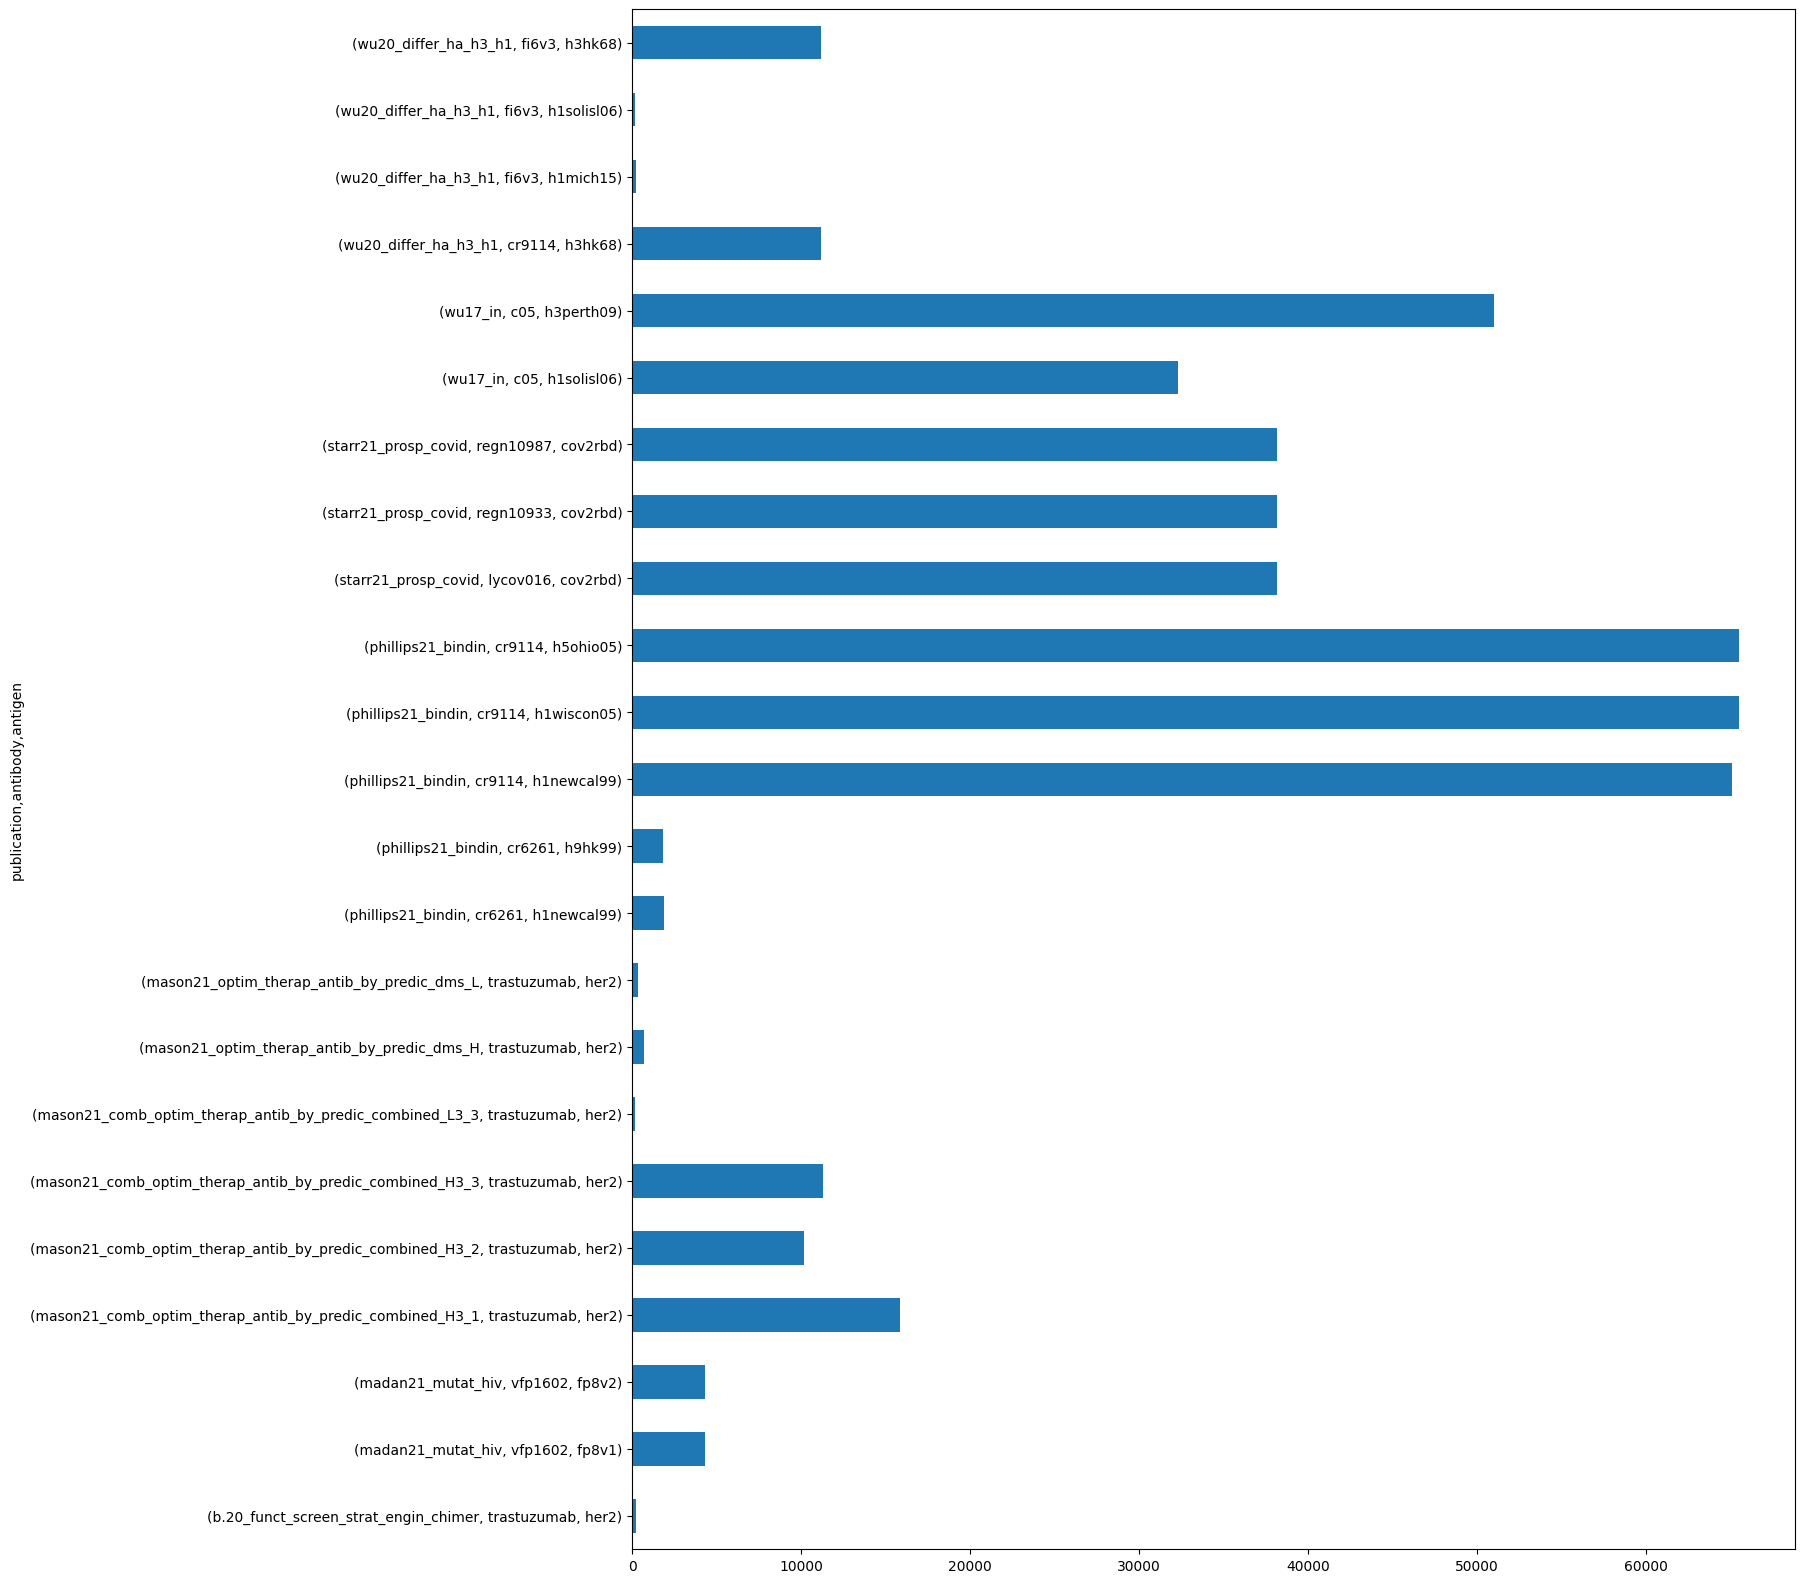

In [59]:
complexes["mutation_code"].count().plot(kind="barh", figsize=(15, 20))

## Distribution of affinity values

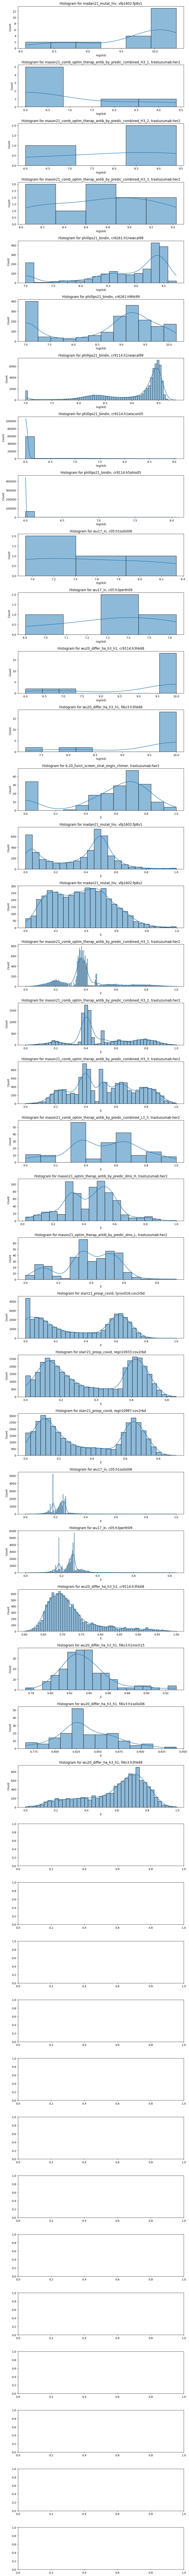

In [60]:
fig, axs = plt.subplots(figsize=(10,44 * 3), nrows=44)
fig.tight_layout(pad=4.0)

i = 0

for col in ["-log(Kd)","E"]:

    for group, idx in complexes.groups.items():
        group_df = dms_df.iloc[idx]

        if any(group_df[col].notnull()):

            sns.histplot(group_df, x=col, kde=True, ax=axs[i]).set_title(f"Histogram for {group[0]}, {group[1]}:{group[2]}")
            
            wt_values = group_df.loc[group_df["mutation_code"].isna(), col].values
            if len(wt_values) > 0:
                for wt_value in wt_values:
                    if not np.isnan(wt_value):
                        axs[i].axvline(wt_value, color="red")
            i += 1


## Error analysis of generation process

In [61]:
generation_log_path = os.path.join(config["DATA"]["path"], 
                                   config["DATA"]["DMS"]["folder_path"], 
                                   config["DATA"]["DMS"]["mutated_pdb_path"],
                                  "{}/{}_{}.logs")


In [62]:
all_logs = []
nologs = []

for group, idx in complexes.groups.items():
    publication, antibody, antigen = group
    group_log_path = generation_log_path.format(publication, antibody, antigen)
    if os.path.exists(group_log_path):
        group_logs = pd.read_csv(group_log_path)
        group_logs["publication"] = publication
        group_logs["antibody"] = antibody
        group_logs["antigen"] = antigen
        all_logs.append(group_logs)
    else:
        print(f"No logs available for {publication}:{antibody}:{antigen}")
        nologs.append(f"{publication}:{antibody}:{antigen}")
        
all_logs = pd.concat(all_logs)
all_logs.reset_index(inplace=True, drop=True)


In [68]:
publications = dms_df.groupby("publication")
for publication, idx in publications.groups.items():
    print(publication, ":", len(dms_df.iloc[idx]["mutation_code"].unique()))
    print()

b.20_funct_screen_strat_engin_chimer : 191

madan21_mutat_hiv : 1

mason21_comb_optim_therap_antib_by_predic_combined_H3_1 : 15834

mason21_comb_optim_therap_antib_by_predic_combined_H3_2 : 10149

mason21_comb_optim_therap_antib_by_predic_combined_H3_3 : 11306

mason21_comb_optim_therap_antib_by_predic_combined_L3_3 : 186

mason21_optim_therap_antib_by_predic_dms_H : 695

mason21_optim_therap_antib_by_predic_dms_L : 341

phillips21_bindin : 9181

starr21_prosp_covid : 2

wu17_in : 1

wu20_differ_ha_h3_h1 : 5677



In [75]:
dms_df[(dms_df["publication"] == "wu17_in") & (dms_df["antigen"] == "h1solisl06")]["original_mutation"].tolist()

['QH110A;QH111V;HH112S;YH113L;TH114R;TH115C',
 'QH110G;QH111H;HH112R;TH114R;TH115W',
 'QH110S;QH111P;HH112V;YH113G;TH114D;TH115F',
 'QH110F;HH112A;YH113R;TH114A;TH115W',
 'QH110S;QH111S;HH112T;YH113V;TH114Y;TH115C',
 'QH110V;QH111T;HH112L;YH113R;TH114S;TH115C',
 'QH110V;QH111P;HH112G;YH113V;TH114S;TH115W',
 'QH110G;QH111V;HH112K;YH113V;TH114S;TH115L',
 'QH110A;QH111V;HH112L;YH113R;TH114M;TH115W',
 'QH110V;QH111R;HH112F;YH113S;TH114C;TH115C',
 'QH110R;QH111A;HH112T;YH113C;TH114L;TH115W',
 'QH110R;QH111M;HH112G;YH113H;TH114Q;TH115F',
 'QH110P;QH111A;HH112S;YH113A;TH114V;TH115F',
 'QH110V;QH111D;HH112E;YH113A;TH114R;TH115C',
 'QH110P;QH111S;HH112G;YH113R;TH114N;TH115W',
 'QH110V;QH111S;HH112G;YH113F;TH114V;TH115F',
 'QH110V;QH111S;HH112G;YH113F;TH114V;TH115W',
 'QH110A;QH111I;HH112E;YH113C;TH114K;TH115F',
 'QH110R;QH111F;HH112T;TH114L;TH115C',
 'QH110M;QH111P;HH112G;YH113T;TH114R;TH115Y',
 'QH110M;QH111N;HH112R;YH113K;TH114R;TH115W',
 'QH110W;QH111G;HH112A;YH113V;TH114V;TH115W',
 'QH110G;

In [77]:
full_dms_df[(full_dms_df["publication"] == "wu17_in") & (full_dms_df["antigen"] == "h1solisl06")]["mutation_code"].tolist()

['QH110A;QH111V;HH112S;YH113L;TH114R;TH115C',
 'QH110G;QH111H;HH112R;TH114R;TH115W',
 'QH110S;QH111P;HH112V;YH113G;TH114D;TH115F',
 'QH110F;HH112A;YH113R;TH114A;TH115W',
 'QH110S;QH111S;HH112T;YH113V;TH114Y;TH115C',
 'QH110V;QH111T;HH112L;YH113R;TH114S;TH115C',
 'QH110V;QH111P;HH112G;YH113V;TH114S;TH115W',
 'QH110G;QH111V;HH112K;YH113V;TH114S;TH115L',
 'QH110A;QH111V;HH112L;YH113R;TH114M;TH115W',
 'QH110V;QH111R;HH112F;YH113S;TH114C;TH115C',
 'QH110R;QH111A;HH112T;YH113C;TH114L;TH115W',
 'QH110R;QH111M;HH112G;YH113H;TH114Q;TH115F',
 'QH110P;QH111A;HH112S;YH113A;TH114V;TH115F',
 'QH110V;QH111D;HH112E;YH113A;TH114R;TH115C',
 'QH110P;QH111S;HH112G;YH113R;TH114N;TH115W',
 'QH110V;QH111S;HH112G;YH113F;TH114V;TH115F',
 'QH110V;QH111S;HH112G;YH113F;TH114V;TH115W',
 'QH110A;QH111I;HH112E;YH113C;TH114K;TH115F',
 'QH110R;QH111F;HH112T;TH114L;TH115C',
 'QH110M;QH111P;HH112G;YH113T;TH114R;TH115Y',
 'QH110M;QH111N;HH112R;YH113K;TH114R;TH115W',
 'QH110W;QH111G;HH112A;YH113V;TH114V;TH115W',
 'QH110G;

In [32]:
all_mut = (dms_df["mutation_code"] == dms_df["original_mutation"]).sum()
print(f"In total {all_mut:,} of {len(dms_df):,} jobs have complete mutations ")


different_mut = ((dms_df["mutation_code"] != dms_df["original_mutation"]) & ~dms_df["mutation_code"].isna() & (dms_df["mutation_code"] != "original")).sum()
print(f"In total {different_mut:,} of {len(dms_df):,} jobs have different mutations ")


original = ((dms_df["mutation_code"] == "original")).sum()
print(f"In total {original:,} of {len(dms_df):,} jobs are original pdb (no mutation)")


no_mut = (dms_df["mutation_code"].isna() | (dms_df["mutation_code"] == "original")).sum()
print(f"In total {no_mut:,} of {len(dms_df):,} jobs have no mutations ")


unique_data_points = len(dms_df.groupby("Unnamed: 0").groups.keys())
print(f"In total {unique_data_points:,} of {len(dms_df):,} are unique pdbs ")


print()

some_mut = ((dms_df["mutation_code"] != "original") &  (~dms_df["mutation_code"].isna()) ).sum()
print(f"In total {some_mut:,} of {len(dms_df):,} jobs have some mutations (all or only a part)")

In total 87,869 of 467,815 jobs have complete mutations 
In total 173,481 of 467,815 jobs have different mutations 
In total 206,465 of 467,815 jobs are original pdb (no mutation)
In total 206,465 of 467,815 jobs have no mutations 
In total 70,992 of 467,815 are unique pdbs 

In total 261,350 of 467,815 jobs have some mutations (all or only a part)


In [17]:
dms_df["code"] = dms_df.apply(lambda row: ":".join([row["publication"], row["antibody"], row["antigen"] ]), axis=1)

In [18]:
print("Info for all logs available:", len(dms_df[~dms_df["code"].isin(nologs)]) == len(all_logs))

all_mut = (all_logs["mutation_code"] == all_logs["performed_mutations"]).sum()
print(f"In total {all_mut:,} of {len(all_logs):,} jobs have complete mutations ")


different_mut = ((all_logs["mutation_code"] != all_logs["performed_mutations"]) & ~all_logs["performed_mutations"].isna() & ((all_logs["status"] == "processed") | (all_logs["status"] == "already_processed")) & (all_logs["performed_mutations"] != "[]")).sum()
print(f"In total {different_mut:,} of {len(all_logs):,} jobs have different mutations ")


original = ((all_logs["mutation_code"] == "original")).sum()
print(f"In total {original:,} of {len(all_logs):,} jobs are original pdb (no mutation)")


no_mut = ((all_logs["performed_mutations"].isna()) & ((all_logs["status"] == "processed") | (all_logs["status"] == "already_processed"))).sum()
print(f"In total {no_mut:,} of {len(all_logs):,} jobs have no mutations ")


failed_jobs = ((all_logs["status"] != "processed") & (all_logs["status"] != "already_processed")).sum()
print(f"In total {failed_jobs:,} of {len(all_logs):,} jobs failed")

print()

some_mut = ((all_logs["performed_mutations"] != "[]") &  (~all_logs["performed_mutations"].isna()) ).sum()
print(f"In total {some_mut:,} of {len(all_logs):,} jobs have some mutations (all or only a part)")

Info for all logs available: False
In total 70,839 of 450,896 jobs have complete mutations 
In total 173,481 of 450,896 jobs have different mutations 
In total 14 of 450,896 jobs are original pdb (no mutation)
In total 206,464 of 450,896 jobs have no mutations 
In total 98 of 450,896 jobs failed

In total 244,320 of 450,896 jobs have some mutations (all or only a part)


In [19]:
#tests
assert some_mut == different_mut + all_mut

assert len(all_logs) == failed_jobs + original + no_mut + different_mut + all_mut

#### Get stats about performed mutations

In [20]:
all_logs["num_mutations"] = all_logs["mutation_code"].apply(lambda x: len(x.split(";")) if x != "original" else 0 )
all_logs["num_performed_mutations"] = all_logs["performed_mutations"].apply(lambda x: len(x.split(";")) if isinstance(x, str) and x != "[]" else 0)

all_logs["num_not_performed_mutations"] = all_logs["num_mutations"] - all_logs["num_performed_mutations"]

AttributeError: 'float' object has no attribute 'split'

In [ ]:
all_logs.describe().loc[['mean','std', 'min', 'max']]

In [ ]:
all_logs[all_logs["num_not_performed_mutations"] != 0].describe().loc[['mean','std', 'min', 'max']]

In [ ]:
all_logs[all_logs["status"] != "processed"]

In [ ]:
all_logs

#### Check if all files exist

In [ ]:
generation_files_path = os.path.join(config["DATA"]["path"], 
                                   config["DATA"]["DMS"]["folder_path"], 
                                   config["DATA"]["DMS"]["mutated_pdb_path"],
                                  "all_generated_files.txt")

with open(generation_files_path) as f:
    lines = f.readlines()

lines = [ line.strip().split("/") for line in lines if line.strip()[-4:] == ".pdb"]
lines = [ {"publication": line[1], 
           "antibody": line[2].split("_")[0], 
           "antigen": line[2].split("_")[1],
           "mutation_code": line[3].split(".")[0]
          } for line in lines]

generated_files = pd.DataFrame(lines)

In [ ]:
all_files = all_logs.merge(generated_files, how='left', indicator=True, on=["publication", "antibody", "antigen", "mutation_code"])
all_files[all_files["_merge"] != "both"]

### Check for which files the performed mutation != mutation code

In [ ]:
mutation_not_in_interface = len(all_logs[all_logs["mutation_code"] != all_logs["performed_mutations"]])
print(f"For {mutation_not_in_interface} of {len(all_logs)} ({round(mutation_not_in_interface/len(all_logs)*100, 2)}%) files not all mutations have been in the inferface_hull")

In [ ]:
num_all_complexes = len(all_logs.groupby(["publication", "antibody", "antigen", "mutation_code"]))
unique_complexes = len(all_logs.groupby(["publication", "antibody", "antigen", "performed_mutations"]))
print(f"{unique_complexes} of {num_all_complexes} ({round(unique_complexes/num_all_complexes*100, 2)}%) are unique mutations")

### Get redudancy with AbAg Dataset

In [ ]:
all_logs[all_logs["performed_mutations"] == "SD167R;KD211D;AD216V"]